3D SLAM with Lie Group SE(3), Barfoot.

Transformation Matrix 

At time k,
 
$T_{k} = \begin{bmatrix} {}^{i}C^{v_{k}} &  - {}^{i}C^{v_{k}} {}^{i}r^{v_{k}} \\ 0_{1x3} & 1 \end{bmatrix} \in SE(3)$

where <br>
$^{i}C^{v_{k}}$ is rotation matrix from inertial frame to vehicl (body) frame at time k <br>
$^{i}r^{v_{k}}$ is translation vector from origin of inertial frame to the orgin point of vehicle frame at time k


Error Cost Function

At time k,

$e_{k} = \sum_{j} (y_{k} - T_{k} * p_{j})$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import casadi as ca

In [2]:
def getRotationMat(x_prev , x):
    
    theta = np.arctan2(x[1] - x_prev[1], x[0] - x_prev[0])
    
    return np.array([[np.cos(theta), -np.sin(theta), 0],[np.sin(theta) , np.cos(theta), 0], [0, 0, 1]])

In [13]:
def measure(Rot, x , landmarks, range_max=4):
    """
    @param
    Rot: rotation matrix of the vehicle's orientation
    Trans: Translation  of the vehicle's frame
    x: state of the vehicle in inertial frame
    m: all landmarks in inertial frame
    
    @return
    z_list: list of landmarks observed by the vehicle at time k in body frame
    
    """
    
    z_list = []
    for m in landmarks:
        dm = m - x
        dist = np.linalg.norm(dm , 1)
        
        m_body = np.matmul(Rot , dm)
        
        if dist <= range_max:
            z_list.append(m_body)
            
    return np.array(z_list)
            

In [14]:
def build_cost(T , p , y):
    """
    T: Transformation Matrix [Rot , x]
    p: landmarks 1,..,j observed at time k
    y: measurement 1,...,j at time k
    """
    # covariance for measurement
    Q = ca.SX(3, 3) 
    rng_std = .5
    bearing_std = .5
    pitch_std = 1
    Q[0, 0] = rng_std**2
    Q[1, 1] = bearing_std**2
    Q[2 ,2] = pitch_std**2
    Q_I = ca.inv(Q)
                        
    # build cost
    J = ca.SX.zeros(1,1)
        
    for j in range(len(y)):
        
        e_y = ca.SX.zeros(1,3)
        
        #e_y = y - T * p (from Barfoot) 
        e_y = y[j,:3] - ( ca.mtimes(T[0], p.T) - ca.mtimes(T[0], T[1].T) )
        
        # cost
        J += e_y.T@Q_I@e_y
        
    return J

In [15]:
def build_constraint(R):
    
    #Constraint 1: det(R) = 1
    G1 = ca.SX.zeros(1,1)
    a = R[0,0]
    b = R[1,0]
    c = R[2,0]
    d = R[0,1]
    e = R[1,1]
    f = R[2,1]
    g = R[0,2]
    h = R[1,2]
    i = R[2,2]
    
    G1 = a*e*i + d*h*c + g*b*f - (c*e*g + f*h*a + i*b*d) - 1
    
    #Constraint 2: R^{-1} == R^{T}
    Ainv = ca.inv(R)
    Atrans = R.T
    G2 = ca.SX.zeros(9,1)
    G2[0] = Ainv[0,0] - Atrans[0,0]
    G2[1] = Ainv[0,1] - Atrans[0,1]
    G2[2] = Ainv[0,2] - Atrans[0,2]
    G2[3] = Ainv[1,0] - Atrans[1,0]
    G2[4] = Ainv[1,1] - Atrans[1,1]
    G2[5] = Ainv[1,2] - Atrans[1,2]
    G2[6] = Ainv[2,0] - Atrans[2,0]
    G2[7] = Ainv[2,1] - Atrans[2,1]
    G2[8] = Ainv[2,2] - Atrans[2,2]
    
    G = ca.vertcat(G1 , G2)

    
    return G
    
    

In [27]:
tf = 3
dt = 1

landmarks = np.array([[3,4,0]])

Rot0 = np.identity(3)

Rot1 = getRotationMat([3, 0 , 0] , [6, 4, 0])
Trans1 = np.array([3 , 0 , 0])
ri_to_v1 = np.array([3, 0 ,0])

Rot2 = getRotationMat([6, 4 ,0],[6,6,0])
Trans2 = np.array([3,4,0])
ri_to_v2 = np.array([6,4,0])

#Define true state variable x described in inertial frame
xi = np.array([0.,0.,0.]);
x_prev = xi;

#Define estimated state wrt inetial frame
xh = np.array([xi])
Roth = Rot0

# Symbolic estimated states and landmark
xh_sym = ca.SX.sym('xh0', 1, 3)
Roth_sym = ca.SX.sym('Roth0', 3, 3)
J = ca.SX.zeros(1,1)

hist = {'x': [xi],
        'z': [],
       'R':  [Rot0],
        'xh': [xi],
        'Rh': [Rot0],
       'Frame': [0]};

t_vect = np.arange(0,tf,dt)
print(t_vect)
for k, tk in enumerate(t_vect):

    if tk == 0:
        continue
    
    #Assign translation Input
    if tk == 1:
        u = Trans1;
    elif tk == 2:
        u = Trans2;

    #Assign Rotation input (Rotation Matrix converting frome inertial to body frame at time k)
    if tk == 1:
        Rotk = Rot1;
    elif tk == 2:
        Rotk = Rot2;
        
    #Update State variables
    xk = x_prev + u; 
    
    #Append new estimated state
    Noise = 1;
    xh = np.vstack([xh, xh[-1,:] + u * Noise])
    Roth = np.vstack([Roth, Rotk * Noise])
    
    #Append new estimate symbolic variable
    xh_sym = ca.vertcat(xh_sym, ca.SX.sym('xh'+str(k+1), 1, 3))
    Roth_sym = ca.vertcat(Roth_sym, ca.SX.sym('Roth'+str(k+1), 3, 3))
    
    #Measure landmarks
    zk = measure(Rotk, xk, landmarks)
    # zk = []
    # for j in range(len(z_list)):
    #     temp = np.append(z_list[j] , k)
    #     zk = np.vstack([zk , temp])
        
    #Transformation Matrix
    T = [Roth_sym[-3: , :] , xh_sym[-1 , :]]

    #Update cost function
    J += build_cost(T , landmarks, zk)

    #Re-assign previous state
    x_prev = xk

    #--------------------------------------
    
    #Non-linear programming
    #   for point cloud alignment problem, we are solving for "T" only which include of:
    # - rotation matrix from inertial-frame to vehicle-frame
    # - translation vector describing the vehicle's pose in inertial-frame
    
    nlp = {}                 # NLP declaration
    x_temp = xh_sym.T.reshape((xh_sym.shape[0]*3,1))
    Rot_temp = Roth_sym.T.reshape((Roth_sym.shape[0]*3,1))
    
    G = build_constraint(Roth_sym[-3:, :])
    
    
    nlp['x']= ca.vertcat(x_temp, Rot_temp)       # decision vars
    nlp['f'] = J      # objective
    nlp['g'] = G      # constraints
    
    # Create solver instance
    opts = {'ipopt.print_level':0, 'print_time':0, 'ipopt.sb': 'yes'}
    F = ca.nlpsol('F','ipopt',nlp, opts);

    # Solve the problem using a guess
    x_input = np.hstack([np.array(xh).reshape(-1), Roth.reshape(-1)])
    optim = F(x0=x_input,ubg=0,lbg=0)
    n_x = len(xh)
    n_r = len(Roth)
    xh = np.reshape(optim['x'][0:3*n_x], [n_x,3])    # Best estimate of all states for all times at time i
    Roth = np.reshape(optim['x'][-n_r*3: , :], [n_r,3]) # Best estimate of all rotation matrix at time i
    
    #------------------------------------------------
    
    #Append "true state" history
    hist['x'].append(xk)
    hist['R'].append(Rotk)
    hist['z'].append(zk)
    hist['Frame'].append(k)
    
    #Append "best estimate at time k" history
    hist['xh'].append(xh[-1])
    hist['Rh'].append(Roth[-3: , :])
 
    
for key in hist.keys():
    hist[key] = np.array(hist[key])

cost = float(optim['f'])   
print("cost:" , cost)  
hist

[0 1 2]
cost: 1.8489381808480947e-30


{'x': array([[0., 0., 0.],
        [3., 0., 0.],
        [6., 4., 0.]]),
 'z': array([[[-3.2000000e+00,  2.4000000e+00,  0.0000000e+00]],
 
        [[-1.8369702e-16, -3.0000000e+00,  0.0000000e+00]]]),
 'R': array([[[ 1.000000e+00,  0.000000e+00,  0.000000e+00],
         [ 0.000000e+00,  1.000000e+00,  0.000000e+00],
         [ 0.000000e+00,  0.000000e+00,  1.000000e+00]],
 
        [[ 6.000000e-01, -8.000000e-01,  0.000000e+00],
         [ 8.000000e-01,  6.000000e-01,  0.000000e+00],
         [ 0.000000e+00,  0.000000e+00,  1.000000e+00]],
 
        [[ 6.123234e-17, -1.000000e+00,  0.000000e+00],
         [ 1.000000e+00,  6.123234e-17,  0.000000e+00],
         [ 0.000000e+00,  0.000000e+00,  1.000000e+00]]]),
 'xh': array([[0., 0., 0.],
        [3., 0., 0.],
        [6., 4., 0.]]),
 'Rh': array([[[ 1.000000e+00,  0.000000e+00,  0.000000e+00],
         [ 0.000000e+00,  1.000000e+00,  0.000000e+00],
         [ 0.000000e+00,  0.000000e+00,  1.000000e+00]],
 
        [[ 6.000000e-01, -8.0

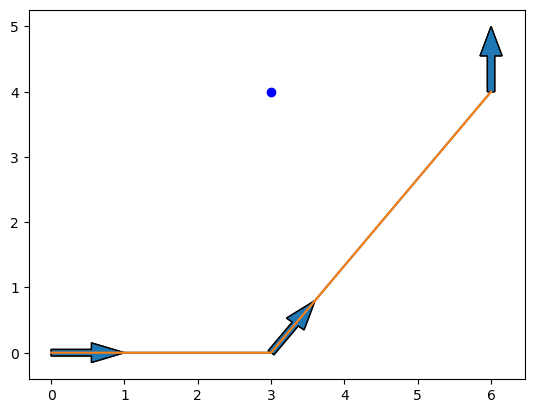

In [28]:
#Plot true vs. estimated state

plt.plot(hist['x'][:, 0] , hist['x'][: , 1])
plt.plot(hist['xh'][:, 0] , hist['xh'][: , 1])

x = hist['x']
Rot = hist['R']
for i in range(len(x)):
    x_temp = np.matmul(Rot[i] , [1 , 0 , 0])
    plt.arrow(x[i,0] , x[i, 1] , x_temp[0] , x_temp[1], width=0.1, length_includes_head=True)
    
xh = hist['xh']
Roth = hist['Rh']
for i in range(len(xh)):
    x_temp = np.matmul(Roth[i] , [1 , 0 , 0])
    plt.arrow(xh[i,0] , xh[i, 1] , x_temp[0] , x_temp[1], width=0.1, length_includes_head=True)
    
#Plot Landmarks
for m in landmarks:
    plt.plot(m[0],m[1],'bo')
    
#Plot measurement
# for zi in hist['z']:
#     i = int(zi[3])
#     plt.arrow(hist['x'][i, 0] , hist['x'][i, 1], np.matmul(Rot[i].T , zi[:3])[0] ,np.matmul(Rot[i].T , zi[:3])[1], width=0.1, length_includes_head=True)